In [1]:
import pandas as pd
import numpy as np

import sklearn.metrics

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
import time

import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error


#from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from IPython.display import display

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes.

 Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. 
 Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. 
 
Tienes que crear un modelo que determine el valor de mercado.

A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

# Preparación de datos

Cargaremos los datos, los exploraremos y prepararemos.

## Diccionario de datos:

**Características**

- *DateCrawled* — fecha en la que se descargó el perfil de la base de datos
- *VehicleType* — tipo de carrocería del vehículo
- *RegistrationYear* — año de matriculación del vehículo
- *Gearbox* — tipo de caja de cambios
- *Power* — potencia (CV)
- *Model* — modelo del vehículo
- *Mileage* — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- *RegistrationMonth* — mes de matriculación del vehículo
- *FuelType* — tipo de combustible
- *Brand* — marca del vehículo
- *NotRepaired* — vehículo con o sin reparación
- *DateCreated* — fecha de creación del perfil
- *NumberOfPictures* — número de fotos del vehículo
- *PostalCode* — código postal del propietario del perfil (usuario)
- *LastSeen* — fecha de la última vez que el usuario estuvo activo


**Objetivo**

- Price — precio (en euros)

## Descripción de datos:

In [2]:
df=pd.read_csv("./car_data.csv")

df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
248639,21/03/2016 20:45,500,small,1996,manual,45,corsa,150000,8,petrol,opel,no,21/03/2016 00:00,0,72149,06/04/2016 23:47
82332,15/03/2016 18:06,9500,sedan,1975,manual,90,kaefer,70000,3,petrol,volkswagen,no,15/03/2016 00:00,0,35633,31/03/2016 23:45
280623,26/03/2016 12:41,2250,wagon,1990,manual,165,100,150000,6,petrol,audi,no,26/03/2016 00:00,0,49565,26/03/2016 12:41
62570,03/04/2016 12:40,7900,sedan,2009,manual,110,golf,125000,3,gasoline,volkswagen,no,03/04/2016 00:00,0,95686,07/04/2016 14:57
310309,05/03/2016 17:58,7000,bus,2009,auto,144,other,40000,4,petrol,kia,no,05/03/2016 00:00,0,12685,08/03/2016 19:46
4177,15/03/2016 10:37,100,NaN,2016,manual,39,swift,150000,1,petrol,suzuki,yes,15/03/2016 00:00,0,1968,15/03/2016 10:37
8914,28/03/2016 09:36,2500,wagon,2000,manual,0,passat,150000,6,gasoline,volkswagen,NaN,28/03/2016 00:00,0,78662,06/04/2016 10:17
26500,14/03/2016 14:48,800,bus,1997,manual,120,espace,150000,0,NaN,renault,no,14/03/2016 00:00,0,98587,23/03/2016 15:16
204927,12/03/2016 18:58,16500,sedan,2010,auto,204,3er,90000,12,gasoline,bmw,no,12/03/2016 00:00,0,93055,15/03/2016 06:17
344228,24/03/2016 13:46,999,wagon,1999,manual,137,mondeo,150000,7,petrol,ford,NaN,24/03/2016 00:00,0,45699,30/03/2016 14:44


#### Datos nulos:
Revisamos la cantidad de datos nulos en todas las columnas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

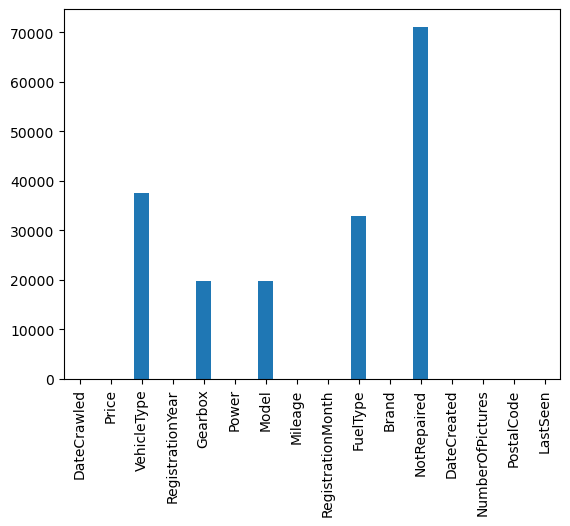

In [5]:
df.isnull().sum().plot(kind='bar')
df.dropna(how='all', inplace=True)
df.info()



#### Revisamos la distribución de los datos:

usando un escalado logaritmico para no omitir las cantidades pequeñas

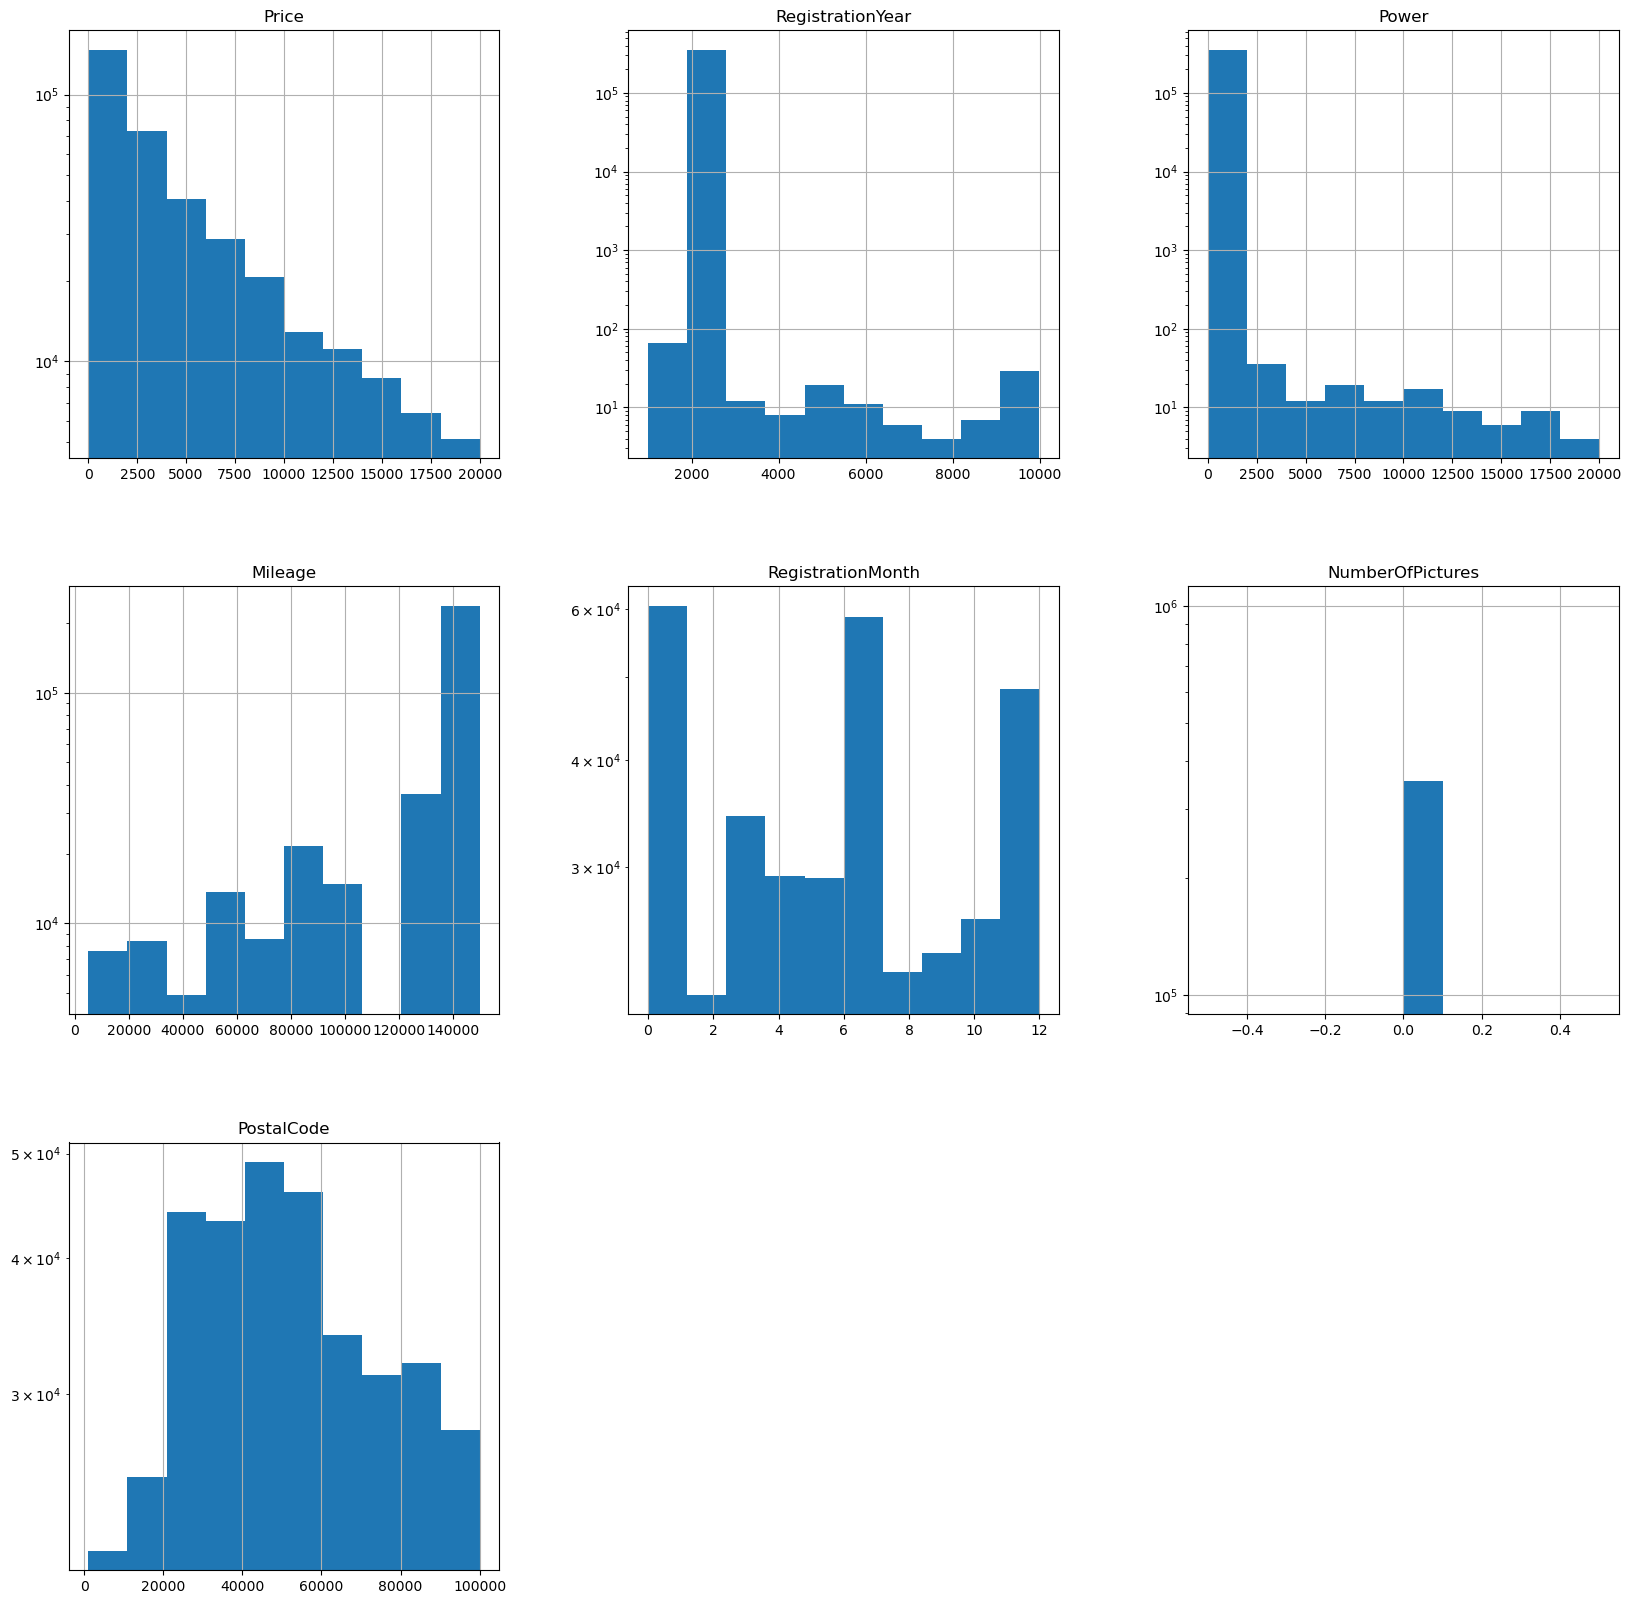

In [6]:
df.hist(figsize=(20, 20),log=True)
plt.show()

## Observaciones:
- Existen caracteristicas (columnas) de nula importancia para los modelos.
- "Notrepaired" debe ser codificado con 0, 1 y nan, quitar el "yes" y "no".
- Notamos que el precio minimo es cero, lo cual debe ser una entrada erronea.
- notamos que la potencia minima tambien es cero, tambien debe ser una entrada erronea.
- notamos que el año de registro minimo es 0 y maximo es 9999 que deben ser otro error.
- existe una importante cantidad de datos nulos en multiples columnas.
- El promedio y la media del precio no coinciden


## Pre-Procesamiento de datos: 
Mejoraremos la calidad del dataframe abordando las observaciones hechas.

### Caracteristicas innecesarias.

Del diccionario de datos podemos determinar que caracteristicas no son relevantes para los modelos, retiramos dichas caracteristicas innecesarias y cualquier entrada duplicada:

In [7]:
df.drop(["PostalCode","LastSeen","NumberOfPictures","DateCreated","RegistrationMonth","DateCrawled"],axis=1,inplace=True)
df.drop_duplicates(inplace=True)


### Codificar "NotRepaired" y rellenar valores faltantes.

In [8]:
df.loc[df["NotRepaired"]=="yes","NotRepaired"]=1
df.loc[df["NotRepaired"]=="no","NotRepaired"]=0

df.fillna({"NotRepaired":"NaN"}, inplace=True)

display(df["NotRepaired"].unique())

array(['NaN', 1, 0], dtype=object)

### Features y objetivos erroneos
Exploramos el objetivo y un par de caracteristicas, pues no deberia haber entradas con precio ni potencia cero, al igual que con años superiores al actual:

In [9]:

print("Elementos con precio igual a cero:",df[df["Price"]==0]["Price"].count())

print("Elementos con potencia igual a cero:",df[df["Power"]==0]["Power"].count())
print("Elementos con un año superior al  actual:",df[df["RegistrationYear"]>2024]["RegistrationYear"].count())
print("Elementos con un año inferior a 1900:",df[df["RegistrationYear"]<1900]["RegistrationYear"].count())




Elementos con precio igual a cero: 8904
Elementos con potencia igual a cero: 35978
Elementos con un año superior al  actual: 99
Elementos con un año inferior a 1900: 63


#### Precio:
Buscamos mas a fondo la distribución del precio:

In [10]:
df.groupby("Price").count().head(10)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
Price,,,,,,,,,
0,6015,8904,7118,8904,7220,8904,6211,8904,8904
1,670,1075,762,1075,867,1075,701,1075,1075
2,8,12,9,12,10,12,10,12,12
3,4,7,4,7,4,7,4,7,7
4,0,1,0,1,0,1,0,1,1
5,15,26,13,26,21,26,10,26,26
7,1,3,1,3,2,3,2,3,3
8,0,6,0,6,1,6,0,6,6
9,4,7,4,7,5,7,4,7,7


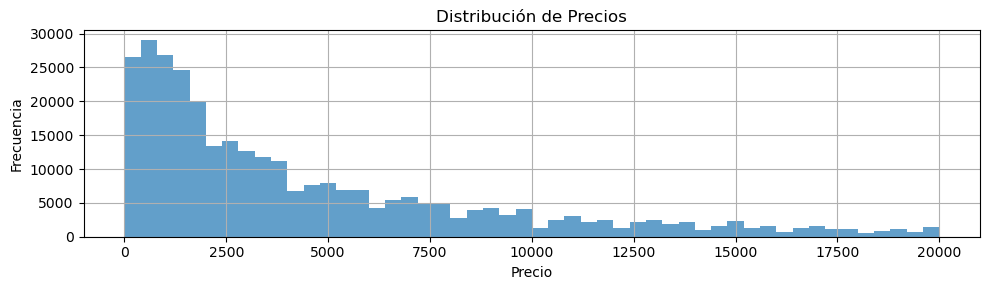

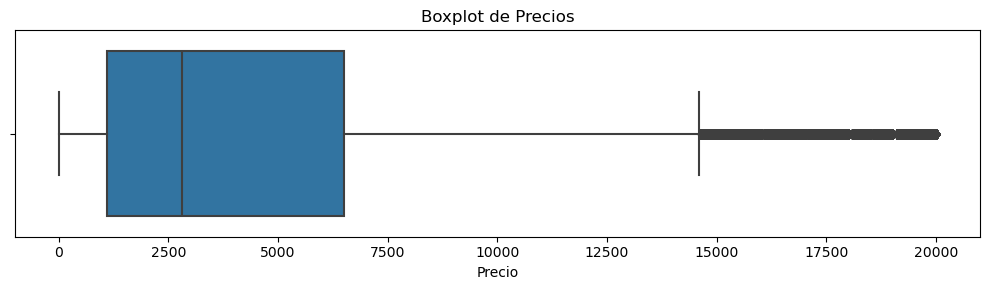

In [11]:
plt.figure(figsize=(10, 3))

df['Price'].plot(kind='hist', bins=50, alpha=0.7)
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['Price'])
plt.title('Boxplot de Precios')
plt.xlabel('Precio')

plt.tight_layout()
plt.show()



Notamos que hay bastantes entradas con valor cero y uno que deben ser corregidas, tambien tenemos multiples valores atipicos con precios bastante altos, estos datos llevaran a sobreestimar precios en los modelos por lo que los datos por encima del bigote superior seran retirados:

$$OutLiers>Q_3+1.5*(Q_3-Q_1)$$

In [12]:
df.loc[df["Price"] == 0, "Price"] =df[df["Price"]!=0]["Price"].median()
df.loc[df["Price"] == 1, "Price"] =df[df["Price"]!=0]["Price"].median()

# Calculate the value of the upper whisker
Bigote_superior = df['Price'].quantile(0.75) + (1.5 * (df['Price'].quantile(0.75) - df['Price'].quantile(0.25)))

df = df[df['Price'] < Bigote_superior].reset_index(drop=True)

df[df["Price"]!=0]["Price"].median()

2800.0

Revisamos el resultado:

In [13]:
df.groupby("Price").count().head(10)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
Price,,,,,,,,,
2,8,12,9,12,10,12,10,12,12
3,4,7,4,7,4,7,4,7,7
4,0,1,0,1,0,1,0,1,1
5,15,26,13,26,21,26,10,26,26
7,1,3,1,3,2,3,2,3,3
8,0,6,0,6,1,6,0,6,6
9,4,7,4,7,5,7,4,7,7
10,36,81,35,81,66,81,41,81,81
11,1,5,1,5,3,5,1,5,5


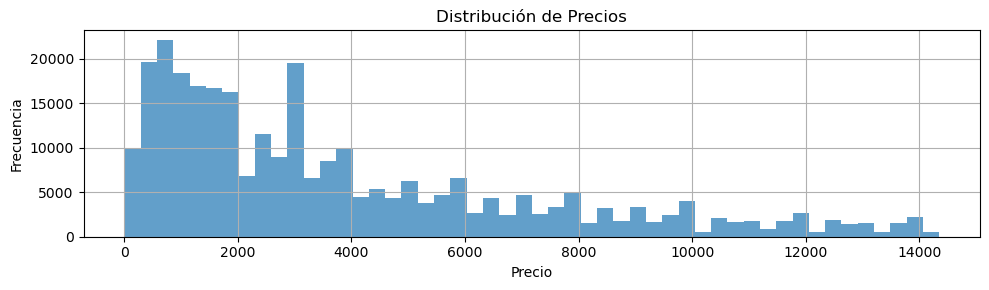

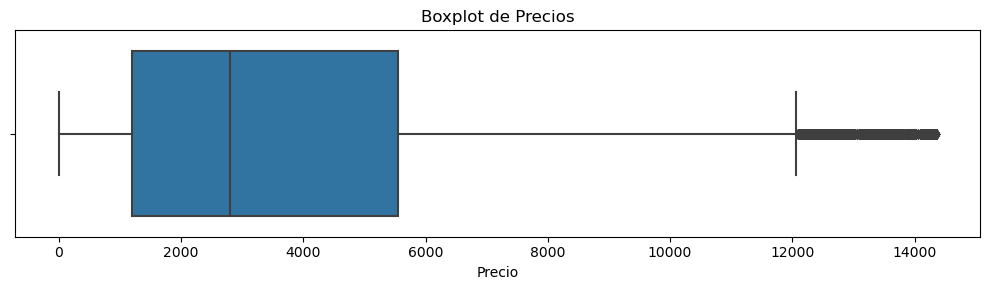

In [14]:
plt.figure(figsize=(10, 3))

df['Price'].plot(kind='hist', bins=50, alpha=0.7)
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['Price'])
plt.title('Boxplot de Precios')
plt.xlabel('Precio')

plt.tight_layout()
plt.show()


#### Año de registro:
Ahora revisaremos el año de registro.

In [15]:
df.groupby("RegistrationYear").count().head(10)

,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
RegistrationYear,,,,,,,,,
1000,34,0,3,34,17,34,6,34,34
1001,1,0,0,1,1,1,0,1,1
1039,1,0,0,1,0,1,1,1,1
1111,3,0,0,3,1,3,0,3,3
1200,1,0,1,1,1,1,1,1,1
1234,4,0,0,4,2,4,1,4,4
1253,1,0,0,1,0,1,0,1,1
1255,1,0,0,1,0,1,0,1,1
1300,2,0,0,2,2,2,0,2,2


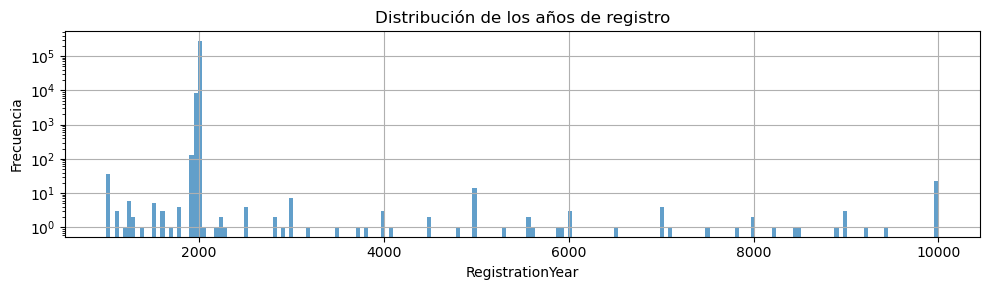

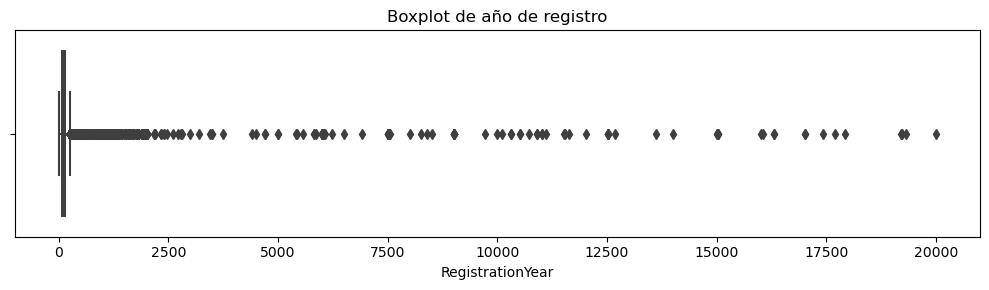

In [16]:
plt.figure(figsize=(10, 3))

df['RegistrationYear'].plot(kind='hist', bins=200, alpha=0.7, log=True)
plt.title('Distribución de los años de registro')
plt.xlabel('RegistrationYear')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['Power'])
plt.title('Boxplot de año de registro')
plt.xlabel('RegistrationYear')

plt.tight_layout()
plt.show()

Tenemos claro que los registros anteriores a 1900 y superiores a 2024 deben ser erroneos y seran descartados.

Reemplazaremos estos datos con la mediana.

In [17]:

df.loc[df["RegistrationYear"] >2024 , "RegistrationYear"] =df[df["RegistrationYear"]!=0]["RegistrationYear"].median()
df.loc[df["RegistrationYear"] <1900, "RegistrationYear"] =df[df["RegistrationYear"]!=0]["RegistrationYear"].median()

print(df["RegistrationYear"].unique())
df[df["RegistrationYear"]!=0]["RegistrationYear"].median()

[1993 2004 2001 2008 1995 1980 1998 2005 1910 2016 2007 2009 2002 2018
 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010 2000 1992
 2013 1996 1985 1989 2011 1982 2014 1976 1973 2015 1969 1971 1987 1986
 1983 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977 1961
 1960 1966 1975 1963 1964 1954 1958 1967 1959 1941 1962 1929 1957 1949
 1940 2019 1937 1951 1953 1933 1950 1952 1942 1935 1956 1936 1923 1930
 1944 1934 1938 1943 1928 1919 1932 1948 1931 1915 1920 1946]


2003.0

Revisamos el efecto de los cambios:

In [18]:
df.groupby("RegistrationYear").count().head(10)

,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
RegistrationYear,,,,,,,,,
1910,80,28,25,80,37,80,24,80,80
1915,1,1,0,1,0,1,0,1,1
1919,1,1,1,1,1,1,1,1,1
1920,1,1,0,1,0,1,1,1,1
1923,2,2,2,2,2,2,2,2,2
1925,1,1,0,1,0,1,0,1,1
1928,2,2,1,2,2,2,1,2,2
1929,5,5,3,5,3,5,4,5,5
1930,2,2,2,2,2,2,2,2,2


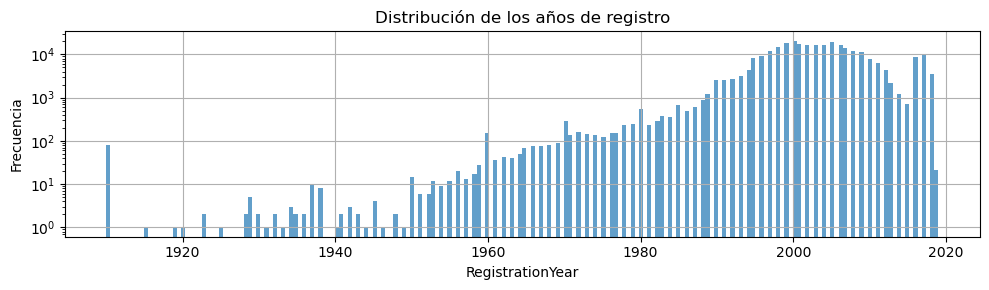

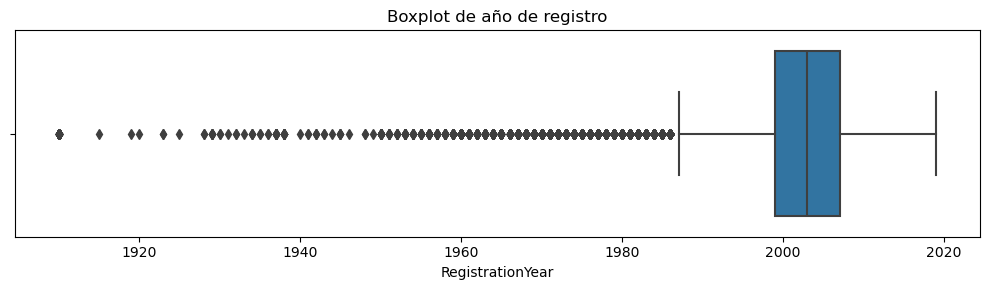

In [19]:
plt.figure(figsize=(10, 3))

df['RegistrationYear'].plot(kind='hist', bins=200, alpha=0.7, log=True)
plt.title('Distribución de los años de registro')
plt.xlabel('RegistrationYear')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['RegistrationYear'])
plt.title('Boxplot de año de registro')
plt.xlabel('RegistrationYear')

plt.tight_layout()
plt.show()

#### Potencia:

Ahora exploramos los valores mas comunes de pontencia y su distribución usando un ajuste logaritmico al eje **y** para apreciar la cantidad de outliers

In [20]:
df.groupby("Power").count().head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Model,Mileage,FuelType,Brand,NotRepaired
Power,,,,,,,,,
0,35407,22531,35407,24634,29968,35407,25224,35407,35407
1,32,25,32,26,21,32,24,32,32
2,9,8,9,8,4,9,7,9,9
3,9,8,9,9,1,9,8,9,9
4,26,23,26,26,5,26,22,26,26
5,96,89,96,92,15,96,89,96,96
6,11,11,11,11,4,11,8,11,11
7,11,10,11,10,3,11,11,11,11
8,7,6,7,6,5,7,6,7,7


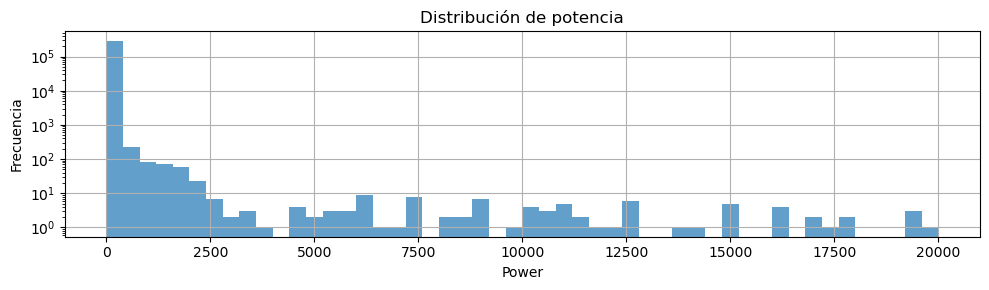

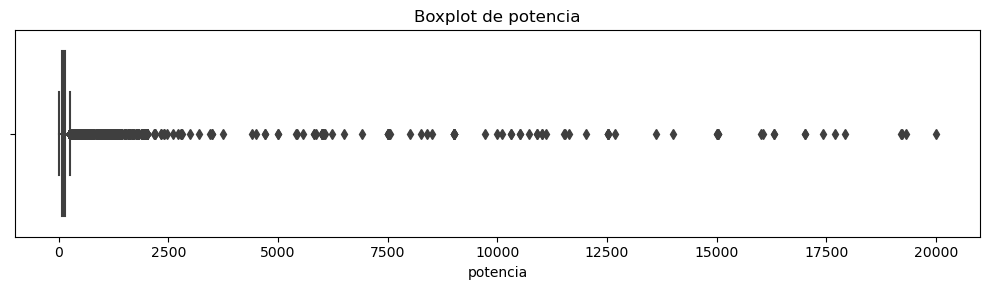

In [21]:
plt.figure(figsize=(10, 3))

df['Power'].plot(kind='hist', bins=50, alpha=0.7,log=True)
plt.title('Distribución de potencia')
plt.xlabel('Power')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['Power'])
plt.title('Boxplot de potencia')
plt.xlabel('potencia')

plt.tight_layout()
plt.show()

Notamos que existe un exceso de datos con valor cero, al igual que muchos datos con valores irrealmente bajos, necesitamos corregir esta caracteristica, para ello haremos un pequeño modelo de regresión lineal que calcule los valores para las entradas con potencia cero, luego descartareamos las entradas con valores atipicamente pequeños y grandes.

In [22]:
features = df[['Price', 'RegistrationYear', 'Mileage']]
target = df['Power']

# Dividir los datos en entrenamiento y prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(features_train, target_train)

# Predecir los valores de Power para las entradas con valores cero
missing_power = df[df['Power']==0]

predicted_power = model.predict(missing_power[['Price', 'RegistrationYear', 'Mileage']])

df.loc[df['Power']==0, 'Power'] = np.int64(predicted_power)

Descartamos outliers con la distancai intercuartil:

In [23]:
Q1 = df['Power'].quantile(0.25)
Q3 = df['Power'].quantile(0.75)
IQR = Q3 - Q1

Bigote_inferior = Q1 - 1.5 * IQR
Bigote_superior= Q1 + 1.5 * IQR

# Identificar valores atípicamente pequeños
df = df[df['Power'] > Bigote_inferior].reset_index(drop=True)
df = df[df['Power'] < Bigote_superior].reset_index(drop=True)

Verificamos el efecto del procesamiento:

In [24]:
df.groupby(by='Power').count().head(10)

,Price,VehicleType,RegistrationYear,Gearbox,Model,Mileage,FuelType,Brand,NotRepaired
Power,,,,,,,,,
1,32,25,32,26,21,32,24,32,32
2,9,8,9,8,4,9,7,9,9
3,9,8,9,9,1,9,8,9,9
4,26,23,26,26,5,26,22,26,26
5,96,89,96,92,15,96,89,96,96
6,11,11,11,11,4,11,8,11,11
7,11,10,11,10,3,11,11,11,11
8,8,7,8,7,6,8,7,8,8
9,54,11,54,6,29,54,9,54,54


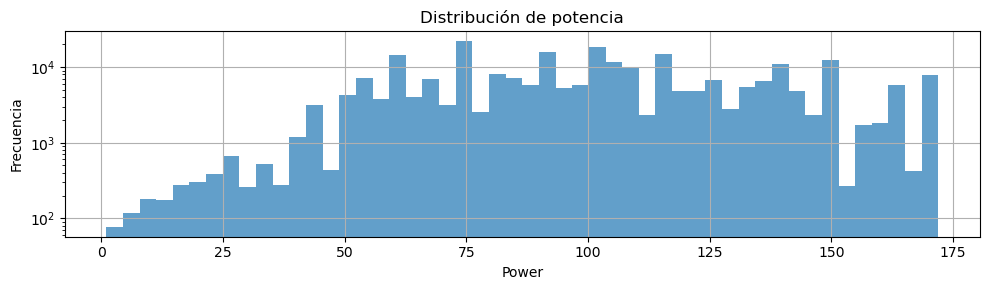

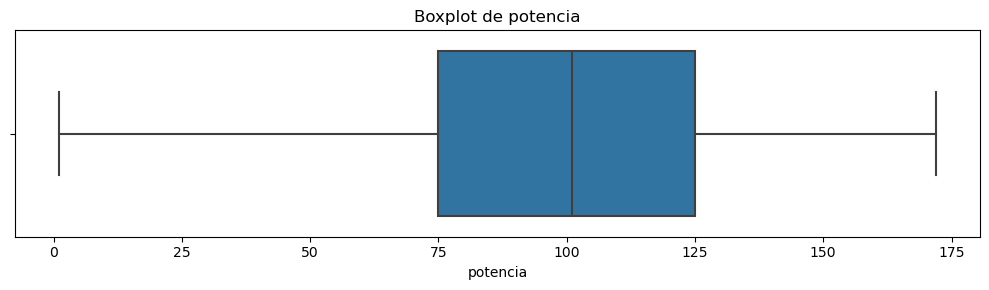

In [25]:
plt.figure(figsize=(10, 3))

df['Power'].plot(kind='hist', bins=50, alpha=0.7,log=True)
plt.title('Distribución de potencia')
plt.xlabel('Power')
plt.ylabel('Frecuencia')
plt.grid(True)


plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))


sns.boxplot(x=df['Power'])
plt.title('Boxplot de potencia')
plt.xlabel('potencia')

plt.tight_layout()
plt.show()

### Datos nulos

In [26]:
#df.dropna(inplace=True)
df.dropna(how='all', inplace=True)
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261009 entries, 0 to 261008
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             261009 non-null  int64 
 1   VehicleType       228876 non-null  object
 2   RegistrationYear  261009 non-null  int64 
 3   Gearbox           244707 non-null  object
 4   Power             261009 non-null  int64 
 5   Model             244953 non-null  object
 6   Mileage           261009 non-null  int64 
 7   FuelType          232930 non-null  object
 8   Brand             261009 non-null  object
 9   NotRepaired       261009 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.9+ MB


,Price,RegistrationYear,Power,Mileage
count,261009.000000,261009.000000,261009.000000,261009.000000
mean,3474.832626,2002.823949,101.820539,128112.421411
std,3167.602016,7.669421,33.549877,37798.935304
min,2.000000,1910.000000,1.000000,5000.000000
25%,1050.000000,1999.000000,75.000000,125000.000000
50%,2500.000000,2003.000000,101.000000,150000.000000
75%,4900.000000,2007.000000,125.000000,150000.000000
max,14350.000000,2019.000000,172.000000,150000.000000


In [27]:
df.isnull().sum()


Price                   0
VehicleType         32133
RegistrationYear        0
Gearbox             16302
Power                   0
Model               16056
Mileage                 0
FuelType            28079
Brand                   0
NotRepaired             0
dtype: int64

Como tenemos aun datos faltantes en columnas categoricas y modelos como "catboost" no aceptan "nan", rellenaremos con "Nan" al igual que se hizo para "NotRepaired":


In [28]:
df.fillna(value='NaN', inplace=True)
df.isnull().sum()


Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Mileage             0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

### Codificamos el set para poder usar bosque aleadorio y regresión lineal:

In [29]:
df_ohe=(pd.get_dummies(df,drop_first=True))


In [30]:
display(df.columns)
display(df_ohe.columns)

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Mileage', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

Index(['Price', 'RegistrationYear', 'Power', 'Mileage', 'VehicleType_bus',
       'VehicleType_convertible', 'VehicleType_coupe', 'VehicleType_other',
       'VehicleType_sedan', 'VehicleType_small',
       ...
       'Brand_smart', 'Brand_sonstige_autos', 'Brand_subaru', 'Brand_suzuki',
       'Brand_toyota', 'Brand_trabant', 'Brand_volkswagen', 'Brand_volvo',
       'NotRepaired_1', 'NotRepaired_NaN'],
      dtype='object', length=310)

### División del dataset:
Dividiremos los datos de ambos dataframes en datos de entrenamiento y de validación.
- train: 75%
- validation: 25%

Dataset normal

In [31]:
features = df.drop("Price",axis=1)
target = df["Price"]

features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=54321, test_size =0.75) 


Dataset con one hot encoding:

In [32]:
features = df_ohe.drop("Price",axis=1)
target = df_ohe["Price"]

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features, target, random_state=54321, test_size =0.75) 


#### Escalado de características:


En algunos modelos necesario escalar los datos para que no se considere ningun valor privilegiado sobre los demas; tambien es necesario que el Escalado se haga sobre el conjunto de entrenamiento y se aplique alconjunto de validación con los mismos parametros para evitar el "data leakeage".

In [33]:
Numeric = features_train.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
scaler.fit(features_train[Numeric])
features_train[Numeric]=scaler.transform(features_train[Numeric])
features_valid[Numeric]=scaler.transform(features_valid[Numeric])

scaler2 = StandardScaler()
scaler2.fit(features_train_ohe[Numeric])
features_train_ohe[Numeric]=scaler2.transform(features_train_ohe[Numeric])
features_valid_ohe[Numeric]=scaler2.transform(features_valid_ohe[Numeric])

# Entrenamiento de  modelos:

Debido a que nuestro objetivo es cuantitativo, ocuparemos modelos de regresión tales como Bosque aleatorio de regresión, regresión lineal y metodos de potenciación de gradiente, entrenaremos los modelos en dicho orden.


### Árbol de decisión de regresión:

Modelo de árbol de decisión de regresión tradicional de parte de sklearn, este usa los datasets ya definidos sin cambio alguno, iteraremos a través de multiples hiperparametros.

In [34]:
%%time 
start_time = time.time()

best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 11):
    model = DecisionTreeRegressor(max_depth= depth, random_state=12345)
    model.fit(features_train_ohe,target_train_ohe) 
    predictions_valid_ohe = model.predict(features_valid_ohe) 
    result = (mean_squared_error(target_valid_ohe,predictions_valid_ohe))**0.5
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth
    
end_time = time.time()
tree_time= end_time - start_time
error_tree=best_result
print(f"RECM del mejor modelo en el conjunto de validación: {best_result} con una profundidad maxima de {best_depth})")

RECM del mejor modelo en el conjunto de validación: 1560.0236416352136 con una profundidad maxima de 10)
CPU times: total: 4.81 s
Wall time: 5.28 s


### Bosque de decisión de regresión:
Modelo de bosque de regresión tradicional de parte de sklearn, al estar compuesto de multiples arboles suele ser tener menor error y mayor tiempo de entrenamiento.

In [35]:
%%time 
start_time = time.time()

best_error = 10000 # configura el inicio de RECM
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model = RandomForestRegressor(random_state=54321, n_estimators=est , max_depth=depth)
        model.fit(features_train_ohe,target_train_ohe) 
        predictions_valid_ohe = model.predict(features_valid_ohe) 
        error = (mean_squared_error(target_valid_ohe,predictions_valid_ohe))**0.5 
        #print("Validación RECM para los n_estimators de", est, ", depth=", depth, "is", error)
        if error < best_error: 
            best_error = error
            best_est = est
            best_depth = depth
error_forest=best_error
end_time = time.time()
forest_time= end_time - start_time

print("\nRECM del mejor modelo en el conjunto de validación:", error_forest,"\nHiperparametros:\n- n_estimators:", best_est, "\n- best_depth:", best_depth)



RECM del mejor modelo en el conjunto de validación: 1453.664146659516 
Hiperparametros:
- n_estimators: 50 
- best_depth: 10
CPU times: total: 5min 7s
Wall time: 5min 29s


### Regresión lineal:

In [36]:
%%time
start_time=time.time()
model = LinearRegression()
model.fit(features_train_ohe, target_train_ohe) 
predictions_valid_ohe = model.predict(features_valid_ohe) 

result =mean_squared_error(target_valid_ohe,predictions_valid_ohe)**0.5 



print("RECM del modelo de regresión lineal en el conjunto de validación:", result)
error_regresion=result
end_time = time.time()
regresión_time= end_time - start_time


RECM del modelo de regresión lineal en el conjunto de validación: 8006987548495.0625
CPU times: total: 1.67 s
Wall time: 683 ms


El uso de tantas caracteristicas codificadas con OHE entorpece este modelo, probaremos usar solo las caracteristicas numericas:

In [37]:
display(features_valid_ohe[Numeric])



,RegistrationYear,Power,Mileage
122738,-0.625138,-1.425920,0.577943
212308,-0.104440,0.578625,0.577943
3396,0.806782,1.147078,0.577943
93281,-0.494963,-1.246409,-0.086327
203525,0.676607,1.835205,0.577943
...,...,...,...
51820,0.936956,-0.797630,-0.086327
54320,-0.234614,-0.498444,0.577943
89538,0.025735,-1.246409,0.577943
114295,0.416258,0.429032,-2.344844


In [38]:
%%time

start_time=time.time()
model = LinearRegression()
model.fit(features_train_ohe[Numeric], target_train_ohe) 
predictions_valid_ohe = model.predict(features_valid_ohe[Numeric]) 

result =mean_squared_error(target_valid_ohe,predictions_valid_ohe)**0.5 

print("RECM del modelo de regresión lineal en el conjunto de validación:", result)
error_regresion=result
end_time = time.time()
regresión_time= end_time - start_time

RECM del modelo de regresión lineal en el conjunto de validación: 2399.0293910596374
CPU times: total: 78.1 ms
Wall time: 44.5 ms


Lo cual nos da un error razonable aunque no ideal.

### Catboost: Potenciación del gradiente
Ahora usaremos CatBoost para entrenar una potenciación del gradiente que se basa en arboles de decisión:

Para esto no es necesario usar el dataframe codificado con *OHE*, pero si es necesario indicarle al modelo que columnas son categoricas.
Así, primero obtenemos los indices de las columnas categoricas de "features_train":

In [39]:
categorias = features_train.select_dtypes(include=['object']).columns
print(categorias)
indices_categorias = [features_train.columns.get_loc(categoria) for categoria in categorias]
print("Índices de las columnas categóricas:", indices_categorias)


Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], dtype='object')
Índices de las columnas categóricas: [0, 2, 4, 6, 7, 8]


Tras ello, el algoritmo se implementa de forma muy similar a sklearn:

In [40]:
%%time
start_time= time.time()
best_error = 10000
best_est = 0
best_depth = 0

# Iterar sobre diferentes hiperparámetros
for est in range(10, 51, 10):
    for depth in range(1, 11):
        model = CatBoostRegressor(iterations=est, depth=depth, random_seed=54321, learning_rate=0.1,loss_function='RMSE',task_type="GPU", verbose=0)

        model.fit(features_train, target_train, cat_features=indices_categorias)
        predictions_valid = model.predict(features_valid)
        error = np.sqrt(mean_squared_error(target_valid, predictions_valid))
        #print(f"Validación RECM para los n_estimators de {est}, depth={depth} es {error}")
        if error < best_error:
            best_error = error
            best_est = est
            best_depth = depth
error_catboost=best_error
end_time = time.time()
catboost_time= end_time - start_time
print(f"RECM del mejor modelo en el conjunto de validación: {best_error}, n_estimators: {best_est}, best_depth: {best_depth}")


RECM del mejor modelo en el conjunto de validación: 1361.9327845595672, n_estimators: 50, best_depth: 10
CPU times: total: 49 s
Wall time: 45.1 s


De primera instnacia notamos la diferencia en el tiempo de entrenamiento, a través del uso del GPU, permitiendo entrenar en menos de 60 segundos lo que con un arbol común requirió alrededor de 5 minutos.


### LightGBM: potenciación de gradiente
Ahora entrenaremos un arbol a través de LightGBM, para esto primero tenemos que realizar un pequeño pre-proceso diferente a OHE a las caracteristicas categoricas:


In [41]:
categorical_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

for col in categorical_features:
    df[col] = df[col].astype('category').cat.codes
display(df)
df.info()


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
0,480,0,1993,2,90,117,150000,7,38,2
1,9800,7,2004,1,163,118,125000,3,14,2
2,1500,6,2001,2,75,117,150000,7,38,0
3,3600,6,2008,2,69,102,90000,3,31,0
4,650,5,1995,2,102,11,150000,7,2,1
...,...,...,...,...,...,...,...,...,...,...
261004,2900,0,2005,2,105,79,150000,7,22,1
261005,2200,0,2005,0,42,26,20000,0,33,2
261006,1199,2,2000,1,101,107,125000,7,32,0
261007,9200,1,1996,2,102,223,150000,3,38,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261009 entries, 0 to 261008
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   Price             261009 non-null  int64
 1   VehicleType       261009 non-null  int8 
 2   RegistrationYear  261009 non-null  int64
 3   Gearbox           261009 non-null  int8 
 4   Power             261009 non-null  int64
 5   Model             261009 non-null  int16
 6   Mileage           261009 non-null  int64
 7   FuelType          261009 non-null  int8 
 8   Brand             261009 non-null  int8 
 9   NotRepaired       261009 non-null  int8 
dtypes: int16(1), int64(4), int8(5)
memory usage: 9.7 MB


Ahora volvemos a dividir el dataframe preprocesado en caracteristicas y objetivos, entrenamiento y validación:

In [42]:

features = df.drop("Price",axis=1)
target = df["Price"]

features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=54321, test_size =0.75) 

LightGBM requiere definir sus datasets a través de "lgb.Dataset" indicandole que columnas son categoricas con:

```categorical_feature=indices_categorias```

y no liberando los dataframes 

```free_raw_data=False```

In [43]:

train_data = lgb.Dataset(features_train, label=target_train, categorical_feature=indices_categorias, free_raw_data=False)
valid_data = lgb.Dataset(features_valid, label=target_valid, reference=train_data, free_raw_data=False)


Ahora entrenaremos el modelo de forma iterativa, donde se crea el diccionario "params" que define a los modelos, usando parametros similares a los modelos anteriores, como estar basado en potenciación del gradiente para arboles de decisión, buscar optmizar la raiz del error cuadratico medio, etc.

El concepto de cada parametro se encuentran en el codigo.

In [44]:

%%time
start_time=time.time()
best_error = 10000
best_est = 0
best_depth = 0

for est in range(10, 51, 10):
    for depth in range(1, 11):
        num_leaves = max(2, 2**depth - 1)
        params = {
            'objective': 'regression', #Tipo de modelo
            'metric': 'rmse', #Metrica objetivo
            'boosting_type': 'gbdt', #tipo de boosting, Gradient Boost Desicion Tree, 
            'num_leaves': num_leaves, #Cantidad de nodos finales del arbol, los cuales son ponderados para obtener el resultado final.
            'learning_rate': 0.1,
            #'n_estimators': est,
            'device': 'gpu',  # Usar GPU para el entrenamiento
            'verbose': -1  # disminuir la cantidad de información impresa por cada entrenamiento.

        }
        model = lgb.train(params, train_data, valid_sets=[valid_data], num_boost_round=est)
        predictions_valid = model.predict(features_valid)
        error = np.sqrt(mean_squared_error(target_valid, predictions_valid))
        #print(f"Validación RECM para los n_estimators de {est}, depth={depth} es {error}")
        if error < best_error:
            best_error = error
            best_est = est
            best_depth = depth

error_lightGBM=best_error
end_time = time.time()
lightGBM_time= end_time - start_time
print(f"RECM del mejor modelo en el conjunto de validación: {best_error}, n_estimators: {best_est}, best_depth: {best_depth}")


RECM del mejor modelo en el conjunto de validación: 1251.3251289439115, n_estimators: 50, best_depth: 9
CPU times: total: 8min 26s
Wall time: 58 s


### XGBoost: Potenciación de gradiente

Ahora usaremos XGBoost para entrenar un modelo de las misma forma, este tambien requiere que las columnas categoricas esten codificadas con OHE.


In [45]:
train_data = xgb.DMatrix(features_train_ohe, label=target_train_ohe)
valid_data = xgb.DMatrix(features_valid_ohe, label=target_valid_ohe)

Ahora entrenamos el modelo con su diccionario de parametros:

In [46]:
%%time
start_time=time.time()
best_error = 10000
best_est = 0
best_depth = 0

for est in range(10, 51, 10):
    for depth in range(1, 11):
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': depth,
            'eta': 0.1,
            #'n_estimators': est,
            'tree_method': 'hist',
            'device' : "cuda"  # Usar GPU para el entrenamiento
        }
        model = xgb.train(params, train_data, num_boost_round=est, evals=[(valid_data, 'validation')], verbose_eval=False)
        predictions_valid = model.predict(valid_data)
        error = np.sqrt(mean_squared_error(target_valid, predictions_valid))
        if error < best_error:
            best_error = error
            best_est = est
            best_depth = depth
error_XGBoost=best_error
end_time = time.time()
XGBoost_time= end_time - start_time
print(f"RECM del mejor modelo en el conjunto de validación: {best_error}, n_estimators: {best_est}, best_depth: {best_depth}")

RECM del mejor modelo en el conjunto de validación: 1290.3850209327584, n_estimators: 50, best_depth: 10
CPU times: total: 1min 2s
Wall time: 24.8 s


## Análisis del modelo

Generaremos un pequeño dataframe que resuma el error de los modelos y el tiempo de ejecución:

In [47]:
df_modelos = pd.DataFrame({
    'Modelo': ['Bosque_de_decisión','Arbol_de_decisión', 'regresion_lineal',"catboost","lightGBM","XGBoost"],
    'Error': [error_forest,error_tree, error_regresion, error_catboost, error_lightGBM, error_XGBoost],
    'Tiempo de entrenamiento': [forest_time,tree_time,regresión_time, catboost_time, lightGBM_time,XGBoost_time ]
})
#df_modelos["ratio"]=df_modelos["Tiempo de ejecución"]/df_modelos["Error"]
#df_modelos.sort_values(by="Error",inplace=True)
df_modelos

,Modelo,Error,Tiempo de entrenamiento
0,Bosque_de_decisión,1453.664147,329.903551
1,Arbol_de_decisión,1560.023642,5.275831
2,regresion_lineal,2399.029391,0.044518
3,catboost,1361.932785,45.117953
4,lightGBM,1251.325129,58.037591
5,XGBoost,1290.385021,24.823016


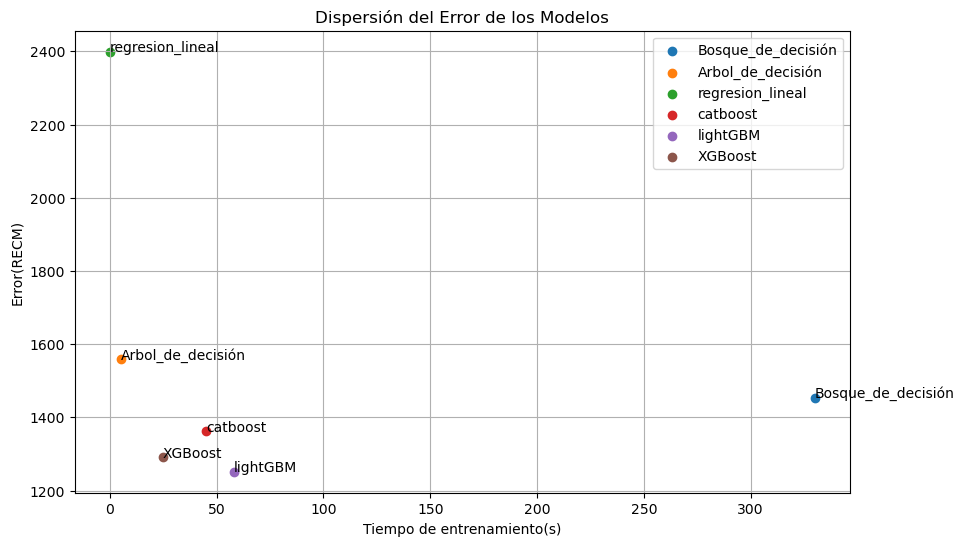

In [48]:
plt.figure(figsize=(10, 6))
for modelo in df_modelos['Modelo']:
    subset = df_modelos[df_modelos['Modelo'] == modelo]
    plt.scatter(subset['Tiempo de entrenamiento'], subset['Error'], label=modelo)
    for i in range(subset.shape[0]):
        plt.text(subset['Tiempo de entrenamiento'].iloc[i], subset['Error'].iloc[i], str(subset['Modelo'].iloc[i]))
plt.title('Dispersión del Error de los Modelos')
plt.xlabel('Tiempo de entrenamiento(s)')
plt.ylabel('Error(RECM)')
plt.grid(True)
plt.legend()
plt.show()


De nuestro grafico podemos notar multiples cosas:
- Todos los modelos tienen un error menor a la regresión lineal, lo cual sirve como **prueba de cordura** para todos los modelos.
- Todos los modelos tienen un tiempo mucho menor al árbol de decisión tradicional

Esto nos deja con cuatro posibles candidatos para mejor modelo:
- Árbol tradicional
- Catboost
- XGBoost
- LightGBM

Haciendo un grafico de dispersión para estos cuatro:


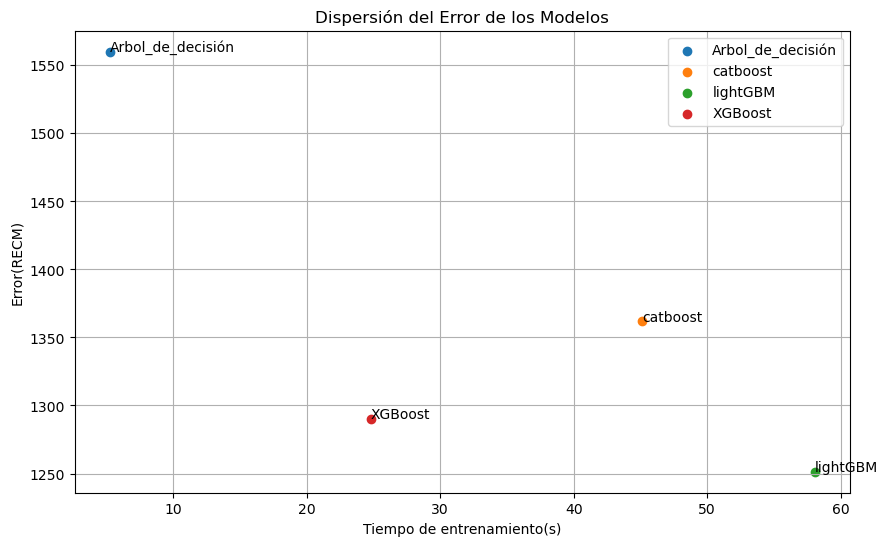

In [49]:
df_modelos.drop([2,0],axis=0,inplace=True)
plt.figure(figsize=(10, 6))
for modelo in df_modelos['Modelo']:
    subset = df_modelos[df_modelos['Modelo'] == modelo]
    plt.scatter(subset['Tiempo de entrenamiento'], subset['Error'], label=modelo)
    for i in range(subset.shape[0]):
        plt.text(subset['Tiempo de entrenamiento'].iloc[i], subset['Error'].iloc[i], str(subset['Modelo'].iloc[i]))
plt.title('Dispersión del Error de los Modelos')
plt.xlabel('Tiempo de entrenamiento(s)')
plt.ylabel('Error(RECM)')
plt.grid(True)
plt.legend()
plt.show()

Dependiendo de la importancia del tiempo de entrenamiento y precisión, podemos decidir si el mejor modelo es XGBoost o un árbol tradicional, de primera instancia proponemos a **XGBoost como mejor modelo** por su buena relación entre tiempo de entrenamiento y error; esto devido a que:
- Catboost  tiene un tiempo entrenamiento alrededor de mas 1.6 veces mas grande.
- LightGBM tiene un tiempo de entrenamiento alrededor de 2.1 veces mas grande.
- El árbol de decisión tradicional tiene un error alrededor de 1.2 mayor
- XGBoost tiene un tiempo de entrenamiento alrededor de 6 veces mayor al de un arbol tradicional.

Proponemos que el mejor modelo es generado con "*XGBoost*" con un error de:

$RECM=1290.385$

y un tiempo de entrenamiento de:

$XGBoost_{time}=24.82s$

y los siguientes hiperparametros: 

$n_{estimators}= 50$

$best_{depth}= 10$

# Conclusiones:



De este proyecto podemos señalar lo siguiente:
- Siempre se debe revisar el estado de los datos de entrenamiento; pues si entra basura, saldrán predicciones basura.
    - Se corrigieron multiples registros numericos nulos en la mayoria de las columnas numericas sin alterar significativamente su estadistica, a traves del uso de la mediana, desechar datos irreales y un modelo lineal.
    - En las columnas categoricas, se etiquetó correctamente los registos nulos.
    - se escalaron correctamente los datos
    - se codificaron los datos con OHE para los modelos que lo requieren.
- Se entrenaron seis modelos iterando a través de sus hiperparametros.
    - Encontramos los mejores candidatos en un espacio de hiperparametros.
    - Hicimos nuestra propuesta de mejor modelo basandonos en las metricas de "RECM" y "tiempo de entrenamiento"
- Observamos de los modelos:
    - La regresión lineal es deficiente en el ajuste de multiples hiperparametros.
    - El árbol de regresión tiene un entrenamiento rapido, pero su error no es optimo.
    - A pesar de entrenar multiples arboles, el bosque aleatorio de regresión tiene un error de calidad media, sin embargo el tiempo que toma en ser entrenado es demasiado.
    - Los algoritmos de descenso del gradiente otorgan errores optimos para esta tarea, son robustos y requieren menos pre-procesamiento de datos.
- Hace falta optimizar los modelos usando GridSearchCV, evitando los bucles *for* y aplicando *validación cruzada*
    
**Considerando las necesidades de  *Rusty Bargain*, proponemos el uso de *XGBoost* para las predicciones de su aplicación, debido a su excelente balance de calidad de predicción y tiempo de entrenamiento.**

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [x ]  El código no tiene errores
- [x ]  Las celdas con el código han sido colocadas en orden de ejecución
- [x ]  Los datos han sido descargados y preparados
- [x ]  Los modelos han sido entrenados
- [x ]  Se realizó el análisis de velocidad y calidad de los modelos